In [2]:
import os
import cv2
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd

In [3]:
import generator as gen

In [4]:
plt.style.use('default')
set_fig_size=(10,5)
set_fig_size2=(6,5)

'''
labels={'ped', ...			% 1
	'person_on_vhcl', ...	% 2
	'car', ...				% 3
	'bicycle', ...			% 4
	'mbike', ...			% 5
	'non_mot_vhcl', ...		% 6
	'static_person', ...	% 7
	'distractor', ...		% 8
	'occluder', ...			% 9
	'occluder_on_grnd', ...		%10
	'occluder_full', ...		% 11
	'reflection', ...		% 12
	'crowd' ...			% 13
	};
    '''

In [5]:
# Explore data availability
index = []
frames = []
instances = []
objects = []
av_frames = []
av_instances = []
match_info = []
missmatch_info = []
all_missmatch_info = []

dir_location = os.path.join('MOT', 'train')
dir_names = os.listdir(dir_location)
dir_names = [n for n in dir_names if n[0] is not '.']  # Filter out hidden files
#dir_names = [n for n in dir_names if n[:5]=='MOT17' and n[-3:]=='DPM']  # Filter for 'MOT17...DPM' folders, note that there are duplicates

def filter_gt(gt_in):
    size = 10000
    dim = 40
    ratio = 0.2
    
    if gt_in[4]*gt_in[5] > size and (gt_in[4] > dim) and (gt_in[5] > dim) and ((gt_in[5]/gt_in[4]) > ratio) and ((gt_in[4]/gt_in[5]) > ratio):
        return True
    else:
        return False
    
for dir_name in sorted(dir_names):
    dir_path = os.path.join(dir_location, dir_name)
    gt_dir = os.path.join(dir_path, 'gt', 'gt.txt')
    gt_name = gt_dir.split('/')[2]
    
    gt = []
    with open(gt_dir) as f:
        for line in f:
            gt.append([int(n) for n in line.strip().split(',')[:-1]]) # Loose last entry which is not an integer
    print('>>> Directory: {}'.format(gt_name))
    
    # Filter gt for certain classes
    classes = [-1, 1, 2, 13]
    gt_class = [line for line in gt if line[7] in classes]

    # Fiter for crop size
    gt_class = [line for line in gt_class if filter_gt(line)]
    
    # Check how many frames are available
    frame_ids = [c[0] for c in gt_class]
    
    # Check how many Ids are available
    ids = [c[1] for c in gt_class]
    
    _num_frames = len(set(frame_ids))
    _num_instances = len(gt_class)
    _num_objects = len(set(ids))
    
    if _num_objects:
        _av_frames = _num_instances/_num_objects
        _av_instances = _num_instances / _num_frames
        _match_info = _num_objects * _av_frames * (_av_frames-1) * 0.5
        _missmatch_info = _num_objects * (_num_objects - 1) * 0.5
        _all_missmatch_info = _num_objects * (_num_objects - 1) * 0.5 * _av_frames * (_av_frames-1) * 0.5

    #     print('{} frames with {} instances and {} unique objects (after filtering)'.
    #           format(_num_frames, _num_instances, _num_objects))
    #     print('Approx. {} frames per object.'.format(_av_frames))

        index.append(gt_name)
        frames.append(_num_frames)
        instances.append(_num_instances)
        objects.append(_num_objects)
        av_frames.append(int(_av_frames))
        av_instances.append(int(_av_instances))
        match_info.append(int(_match_info))
        missmatch_info.append(int(_missmatch_info))
        all_missmatch_info.append(int(_all_missmatch_info))


train_frames = sum(frames)
train_instances = sum(instances)
train_objects = sum(objects)
train_matches = sum(match_info)
train_missmatches = sum(missmatch_info)
train_all_missmatches = sum(all_missmatch_info)

print('\nTotal frames: {}\nTotal instances: {}\nTotal objects: {}\nTotal matches: {}\nTotal missmatches: {}\nAll mismatches: {}'.
     format(train_frames, train_instances, train_objects, train_matches, train_missmatches, train_all_missmatches))

train_data = pd.DataFrame({'frames': frames,
                        'instances': instances,
                        'frames/object': av_frames,
                        'instances/frame': av_instances,
                       'objects': objects,
                       'matches': match_info,
                       'missmatches': missmatch_info}, index=index)


>>> Directory: KITTI_0002
>>> Directory: KITTI_0005
>>> Directory: KITTI_0006
>>> Directory: KITTI_0008
>>> Directory: KITTI_0012
>>> Directory: KITTI_0013
>>> Directory: KITTI_0014
>>> Directory: KITTI_0016
>>> Directory: KITTI_0017
>>> Directory: KITTI_0018
>>> Directory: KITTI_0019
>>> Directory: KITTI_0020
>>> Directory: MOT17-02-DPM
>>> Directory: MOT17-04-DPM
>>> Directory: MOT17-05-DPM
>>> Directory: MOT17-09-DPM
>>> Directory: MOT17-10-DPM
>>> Directory: VTB_above
>>> Directory: VTB_indoors
>>> Directory: VTB_outdoors
>>> Directory: VTB_sports

Total frames: 14285
Total instances: 47360
Total objects: 357
Total matches: 6069305
Total missmatches: 8031
All mismatches: 109763920


In [6]:
train_data['matches_perc'] = train_data.matches / train_data.matches.sum()
train_data['missmatches_perc'] = train_data.missmatches / train_data.missmatches.sum()

In [7]:
train_data

,frames,frames/object,instances,instances/frame,matches,missmatches,objects,matches_perc,missmatches_perc
KITTI_0002,35,35,35,1,595,0,1,0.000098,0.000000
KITTI_0012,34,34,34,1,561,0,1,0.000092,0.000000
KITTI_0013,131,5,193,1,406,666,37,0.000067,0.082929
KITTI_0016,160,24,443,2,5229,153,18,0.000862,0.019051
KITTI_0017,122,36,330,2,5885,36,9,0.000970,0.004483
KITTI_0019,754,30,1747,2,25898,1596,57,0.004267,0.198730
MOT17-02-DPM,600,245,4170,6,509353,136,17,0.083923,0.016934
MOT17-04-DPM,1050,332,18936,18,3135901,1596,57,0.516682,0.198730
MOT17-05-DPM,825,50,4016,4,100069,3081,79,0.016488,0.383638
MOT17-09-DPM,525,197,5131,9,503726,325,26,0.082996,0.040468


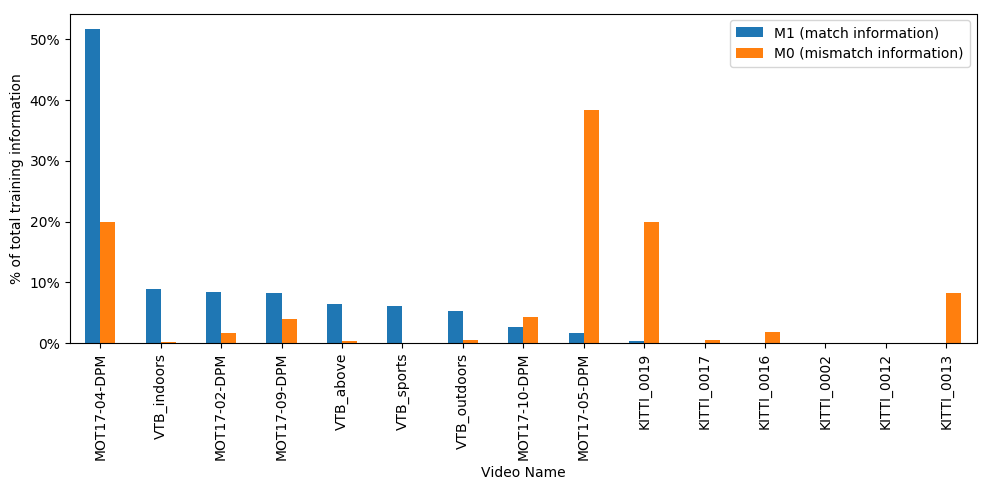

In [8]:
ax = train_data[['matches_perc', 'missmatches_perc']].sort_values('matches_perc', ascending=False).plot.bar(figsize=set_fig_size)
fig = ax.get_figure()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xlabel('Video Name')
ax.set_ylabel('% of total training information')
ax.legend(['M1 (match information)', 'M0 (mismatch information)'])
fig.tight_layout()


In [9]:
#fig.savefig('figures/6_3a.png', bbox_inches='tight')

In [10]:
# Explore data availability
index = []
frames = []
instances = []
objects = []
av_frames = []
av_instances = []
match_info = []
missmatch_info = []
all_missmatch_info = []

dir_location = os.path.join('MOT', 'validate')
dir_names = os.listdir(dir_location)
dir_names = [n for n in dir_names if n[0] is not '.']  # Filter out hidden files
#dir_names = [n for n in dir_names if n[:5]=='MOT17' and n[-3:]=='DPM']  # Filter for 'MOT17...DPM' folders, note that there are duplicates

def filter_gt(gt_in):
    size = 10000
    dim = 40
    ratio = 0.2
    
    if gt_in[4]*gt_in[5] > size and (gt_in[4] > dim) and (gt_in[5] > dim) and ((gt_in[5]/gt_in[4]) > ratio) and ((gt_in[4]/gt_in[5]) > ratio):
        return True
    else:
        return False
    
for dir_name in sorted(dir_names):
    dir_path = os.path.join(dir_location, dir_name)
    gt_dir = os.path.join(dir_path, 'gt', 'gt.txt')
    gt_name = gt_dir.split('/')[2]
    
    gt = []
    with open(gt_dir) as f:
        for line in f:
            gt.append([int(n) for n in line.strip().split(',')[:-1]]) # Loose last entry which is not an integer
    print('>>> Directory: {}'.format(gt_name))
    
    # Filter gt for certain classes
    classes = [-1, 1, 2, 13]
    gt_class = [line for line in gt if line[7] in classes]

    # Fiter for crop size
    gt_class = [line for line in gt_class if filter_gt(line)]
    
    # Check how many frames are available
    frame_ids = [c[0] for c in gt_class]
    
    # Check how many Ids are available
    ids = [c[1] for c in gt_class]
    
    _num_frames = len(set(frame_ids))
    _num_instances = len(gt_class)
    _num_objects = len(set(ids))
    
    if _num_objects:
        _av_frames = _num_instances/_num_objects
        _av_instances = _num_instances / _num_frames
        _match_info = _num_objects * _av_frames * (_av_frames-1) * 0.5
        _missmatch_info = _num_objects * (_num_objects - 1) * 0.5
        

    #     print('{} frames with {} instances and {} unique objects (after filtering)'.
    #           format(_num_frames, _num_instances, _num_objects))
    #     print('Approx. {} frames per object.'.format(_av_frames))

        index.append(gt_name)
        frames.append(_num_frames)
        instances.append(_num_instances)
        objects.append(_num_objects)
        av_frames.append(int(_av_frames))
        av_instances.append(int(_av_instances))
        match_info.append(int(_match_info))
        missmatch_info.append(int(_missmatch_info))
        all_missmatch_info.append(int(_all_missmatch_info))


val_frames = sum(frames)
val_instances = sum(instances)
val_objects = sum(objects)
val_matches = sum(match_info)
val_missmatches = sum(missmatch_info)
val_all_missmatches = sum(all_missmatch_info)

print('\nTotal frames: {}\nTotal instances: {}\nTotal objects: {}\nTotal matches: {}\nTotal missmatches: {}\nAll mismatches: {}'.
     format(val_frames, val_instances, val_objects, val_matches, val_missmatches, val_all_missmatches))

val_data = pd.DataFrame({'frames': frames,
                        'instances': instances,
                        'frames/object': av_frames,
                        'instances/frame': av_instances,
                       'objects': objects,
                       'matches': match_info,
                       'missmatches': missmatch_info}, index=index)

>>> Directory: KITTI_0000
>>> Directory: KITTI_0001
>>> Directory: KITTI_0003
>>> Directory: KITTI_0004
>>> Directory: KITTI_0007
>>> Directory: KITTI_0009
>>> Directory: KITTI_0010
>>> Directory: KITTI_0011
>>> Directory: KITTI_0015
>>> Directory: MOT17-11-DPM
>>> Directory: MOT17-13-DPM
>>> Directory: VTB_skating

Total frames: 3483
Total instances: 11011
Total objects: 98
Total matches: 1014436
Total missmatches: 1450
All mismatches: 5527650


In [46]:
val_data['matches_perc'] = val_data.matches / val_data.matches.sum()
val_data['missmatches_perc'] = val_data.missmatches / val_data.missmatches.sum()

In [47]:
val_data

,frames,frames/object,instances,instances/frame,matches,missmatches,objects,matches_perc,missmatches_perc
KITTI_0000,91,32,96,1,1488,3,3,1.466825e-03,0.002069
KITTI_0001,13,6,19,1,50,3,3,4.928847e-05,0.002069
KITTI_0004,14,4,17,1,27,6,4,2.661577e-05,0.004138
KITTI_0007,6,6,6,1,15,0,1,1.478654e-05,0.000000
KITTI_0009,5,5,5,1,10,0,1,9.857694e-06,0.000000
KITTI_0010,2,2,2,1,1,0,1,9.857694e-07,0.000000
KITTI_0015,71,40,161,2,3159,6,4,3.114046e-03,0.004138
MOT17-11-DPM,900,174,7332,8,636312,861,42,6.272569e-01,0.593793
MOT17-13-DPM,535,44,1527,2,33526,561,34,3.304891e-02,0.386897
VTB_skating,1846,369,1846,1,339848,10,5,3.350118e-01,0.006897


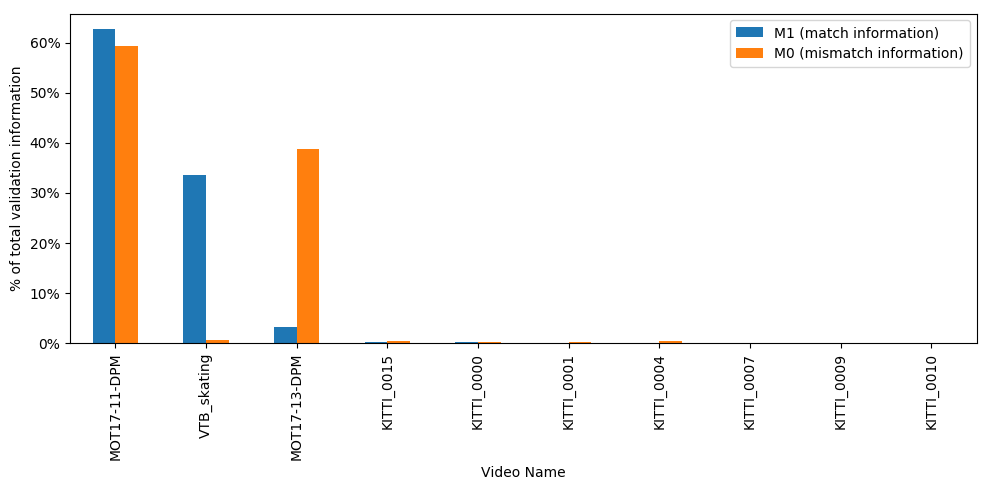

In [49]:
ax = val_data[['matches_perc', 'missmatches_perc']].sort_values('matches_perc', ascending=False).plot.bar(figsize=set_fig_size)
fig = ax.get_figure()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xlabel('Video Name')
ax.set_ylabel('% of total validation information')
ax.legend(['M1 (match information)', 'M0 (mismatch information)'])
fig.tight_layout()

In [50]:
#fig.savefig('figures/6_3b.png', bbox_inches='tight')

In [51]:
index = ['train', 'validate']
summary = pd.DataFrame({'matches': [train_matches, val_matches],
                       'missmatches': [train_missmatches, val_missmatches]}, index = index)
summary['matches_perc'] = summary.matches / summary.matches.sum()
summary['missmatches_perc'] = summary.missmatches / summary.missmatches.sum()

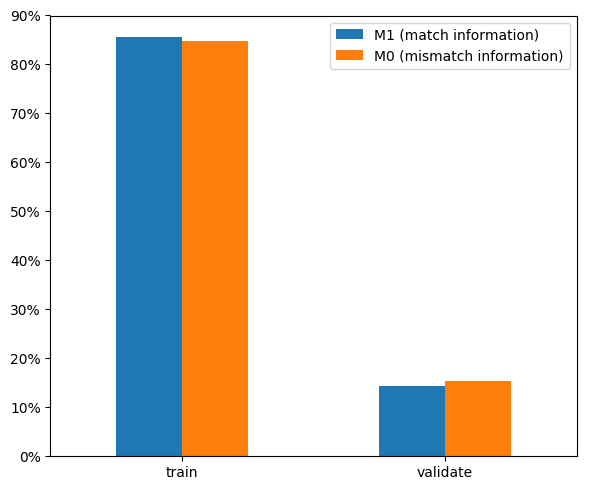

In [53]:
ax = summary[['matches_perc', 'missmatches_perc']].plot.bar(figsize=set_fig_size2, rot=0)
fig = ax.get_figure()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.legend(['M1 (match information)', 'M0 (mismatch information)'])
fig.tight_layout()

In [54]:
#fig.savefig('figures/6_3c.png', bbox_inches='tight')

[Text(0,0,'0.00%'),
 Text(0,0,'20.00%'),
 Text(0,0,'40.00%'),
 Text(0,0,'60.00%'),
 Text(0,0,'80.00%'),
 Text(0,0,'100.00%'),
 Text(0,0,'120.00%')]

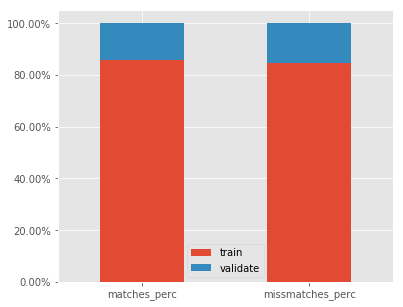

In [34]:
ax = summary[['matches_perc', 'missmatches_perc']].T.plot.bar(figsize=set_fig_size2, stacked=True, rot=0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

In [ ]:
# plt.savefig('path/to/figure.pdf')  # saves the current figure